# HW 2 
Classification with a 2-layer neural network

## 1. Task description

мы будем работать со следующими [данными](https://ru.wikipedia.org/wiki/Ирисы_Фишера)

1. Длина наружной доли околоцветника (англ. sepal length);
2. Ширина наружной доли околоцветника (англ. sepal width);
3. Длина внутренней доли околоцветника (англ. petal length);
4. Ширина внутренней доли околоцветника (англ. petal width).

In [ ]:
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn

import random
import string
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')
%matplotlib inline

In [ ]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, random_state=18, test_size=0.2, shuffle=True)

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Train size: 120 Test size: 30


Поскольку позже будет проще работать с истинными метками, как с кодированными векторами, а не с одиночными целыми числами, вам нужно будет завершить код label_to_onehot, который преобразует вектор меток классов в одно представление.

---
__Notes__:
- Например, если в вашем наборе данных есть классы $k=3$, а вектор истинных меток выглядит $\begin{bmatrix} 2 \\ 1 \\ 0 \\ 1 \end{bmatrix}$ (при условии, что было $N=4$ примеров), тогда окончательное представление меток будет следующим: $\mathbf{y} = \begin{bmatrix} 0 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0 \\ 0 & 1 & 0\end{bmatrix}$




In [ ]:
def labels_to_onehot(labels):
    """
        Convert the indices to one-hot representation
        labels: np.array of labels, shape=(N,)

        return np.array, shape=(N, k)
       """

    n_classes = len(set(labels))
    n_samples = len(labels)

    # create a matrix of zeros of shape (n_samples, n_classes)
    one_hot = 

    # fill one-hot values
    for index in range(len(labels)):
        one_hot[index][labels[index]] = 

    return one_hot

In [ ]:
y_train_ohe = labels_to_onehot(Y_train)
np.shape(y_train_ohe)

(120, 3)

## 2. Neural networks overview

### 2.1 Introduction
Нейронные сети (Neural networks (NNs)) - это алгоритмы машинного обучения (machine learning), которые предназначены для выявления закономерностей (patterns) способом, аналогичным тому, что делает человеческий мозг. NN очень эффективны для обнаружения скрытых структур (latent structures) в немаркированных данных (unlabeled data) и автоматического извлечения (или изучения) соответствующих особенностей (features).

В принципе, существуют различные архитектуры (architectures) NN, которые обычно применяются для решения различных задач. По сути, каждая нейронная сеть состоит из набора вычислительных единиц, называемых нейронами (neurons). Каждый нейрон обрабатывает входной сигнал, вычисляет выходной сигнал и передает (passes) его дальше следующему нейрону. В целом нейроны могут распознавать сложные паттерны. Наша текущая задача будет сосредоточена на простейшем типе нейронной сети - так называемой полносвязанной (fully-connected) нейронной сети.

### Fully-connected neural network
Полносвязанные нейронные сети могут рассматриваться как набор (stack) слоев (layers), где каждый слой состоит из произвольного числа нейронов. Традиционно первый слой называется входным (input) слоем, все средние слои называются скрытыми (hidden) слоями, а последний слой называется выходным (output) слоем. Выходной слой отвечает за принятие окончательных решений высокого уровня и генерацию прогнозов (predictions). Схема прямой (feed-forward) нейронной сети с одним слоем (принято считать только скрытые слои):


<center>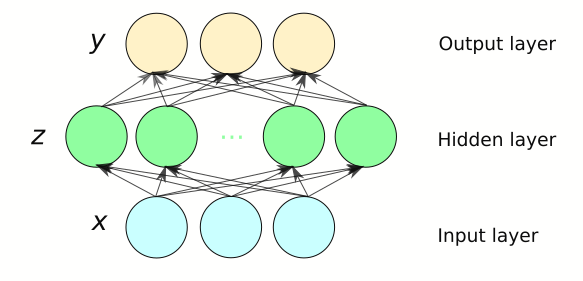</center>

Глубина (depth) нейронной сети является одной из ее ключевых особенностей. Каждый узел (node) одного слоя объединяет выходные данные узлов в предыдущем слое и складывает их в разных пропорциях, то есть с разными весами (weights), и применяет нелинейную (non-linear) функцию к полученному значению. Нелинейность важна, так как набор линейных слоев без нелинейных функций активации (activations) будет эквивалентен только одному линейному слою, что снижает способность нейронной сети восстанавливать сложные структуры во входных данных. Формально, если мы обозначим веса и смещения (weights and the biases) $i$-го слоя в виде матриц (matrices) $W^i$ и $\mathbf{b}$ соответственно, а входной примерный вектор (vector) признаков (feature) - $\mathbf{x}$, тогда преобразование (transformation) $i$-го линейного слоя выглядит следующим образом:


$$ \mathbf{z}^{(i)} = W^{(i)}\mathbf{x} + \mathbf{b} $$
$$ \mathbf{a}^{(i)} = f\left(\mathbf{z}^{(i)}\right)$$

где $f$ - упомянутая нелинейная функция, называемая функцией активации. Существует ряд функций активации, которые широко используются в глубинном обучении (Deep Learning). В задачах классификации (classification) размерность выхода последнего слоя равна количеству классов $k$, а функция активации последнего слоя обычно представляет собой либо сигмоидную (sigmoid) функцию (для задач бинарной (binary) классификации), либо функцию softmax (которая является обобщением сигмоидной функции над задачами многоклассовой (multiclass) классификации).

### 2.2 Softmax function and predictions
Для заданного вектора $\mathbf{z}$ размерности (dimension) $k$ функция softmax вычисляет вектор со следующими компонентами (components):

$$ \text{softmax}\left(\mathbf{z}\right)_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}} $$

Другими словами, функция softmax сначала возводит в степень (exponentiates) вектор (поэлементно (elementwise)), а затем нормализует (normalizes) его так, что все компоненты в сумме дают 1. В выходном слое результирующий вектор можно интерпретировать (interpreted) как распределение (distribution) вероятностей (probability) по классам. Затем сеть делает свой прогноз, выбирая класс с максимальной вероятностью:

$$ \hat{y}_{pred} = \underset{j \in 1..k}{\text{argmax}}\left[\text{softmax}\left(\mathbf{z}\right)\right] $$

Одним интересным свойством функции softmax является то, что она инвариантна (invariant) к постоянному смещению (constant offsets), т.е.
$\text{softmax}\left(\mathbf{z}\right) = \text{softmax}\left(\mathbf{z} + \mathbf{c}\right)$, где $\mathbf{c}$ 
является вектором с стоянными значениями.

Подводя итог, для однослойной нейронной сети предсказанные распределения вероятностей вычисляются как:

$$ \mathbf{\hat{y}} = \text{softmax}\left(W\mathbf{x} + \mathbf{b}\right) $$

### Training
Проще говоря, обучение (training) нейронной сети сводится к оптимизации (optimization) ее предварительно (preliminarily) инициализированных (initialized) весов, так что оптимизация весов будет оптимизировать заданную задачу (objective). Самым популярным алгоритмом оптимизации, используемым в DL, является градиентный спуск (gradient descent). Задача обучения обычно формулируется как максимизация функции правдоподобия (likelihood) на данных для обучения (training data), которая для задач классификации эквивалентна минимизации функции кросс-энтропии (cross-entropy):

$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n \rightarrow \min_{W, b}$$

где $\hat{y}_n$ прогнозируемая вероятность правильного класса $y_n$ для $n$-го обучающего примера, а $N$-общее количество обучающих примеров. Для уменьшения переобучения (overfitting) к функции потерь добавляется дополнительный член, штрафующий (penalizing) большие веса:

$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n + \lambda \Vert W\Vert ^2 \rightarrow \min_{W, b}$$

The actual training is done in iterations such that after every iteration the network produces the predictions, computes the value of the loss function based on the predictions and the ground-truth labels, calculates the gradients through a technique called backpropagation, and then uses the derived gradients to update the weights (a step of the gradient descent algorithm). Backpropagation is the heart of neural networks algorithm; it calculates the gradients of the loss function with respect to every trained weight through application of a series of chain rules. According to the gradient descent algorithm, the weights of the network are updated as:

Фактическое обучение выполняется в итерациях (iterations) таким образом, что после каждой итерации сеть дает предскния, вычисляет значение функции потерь (loss function) на основе прогнозов и меток правильных ответов (ground-truth labels), вычисляет градиенты (gradients) с помощью метода, называемого обратным распространением ошибки (backpropagation), и затем использует полученные градиенты для обновления весов (шаг алгоритма градиентного спуска). Обратное распространение - это ключевой алгоритм обучения нейронных сетей, он вычисляет градиенты функции потерь по отношению к каждому весу путем применения правил дифференцирования сложных функций (chain rules). В соответствии с алгоритмом градиентного спуска веса сети обновляются как:

$$ W_{ij} \leftarrow W_{ij} - \alpha\frac{\partial \mathcal{L}}{\partial W_{ij}} $$

$$ b_{i} \leftarrow b_{i} - \alpha\frac{\partial \mathcal{L}}{\partial b_{i}} $$

где $\alpha$ это гиперпараметр, называемый скоростью обучения (learning rate), который регулирует величину обновлений весов.

На практике обучение проводится партиями (batches): вместо обработки одного обучающего экземпляра (instance) за раз сеть получает несколько примеров, которые обрабатываются параллельно. Помимо эффективности вычислений, этот подход также дает лучшую оценку градиентов.

---
## Now let's code it up!
---


## 3. Step-by-step single-layer network implementation (реализация)

The cell below will be used for unit tests. Please do not modify it.

In [ ]:
# DO NOT MODIFY THIS CELL

# 5 features x 3 classes
W_toy = np.array([[0.2, -0.3, 0.5],
                 [-0.9, 0.6, 0.4],
                 [0.1, 0.7, -0.2],
                 [0.6, 0.1, -0.3],
                 [0.7, -0.1, 0.6]])

# 3 classes
b_toy = np.array([[0.05, 0.1, -0.2]])

# 4 examples x 5 features
x_toy = np.array([[-1.0, -0.7, 0.3, 0.8, 0],
                 [0.5, -0.2, 0.6, 0, -0.4],
                 [0.1, 0, -0.4, -0.1, -0.2],
                 [0.6, 0.7, 0.2, 0.1, 0.4]])

# 3 classes one-hot
y_true_toy = np.array([[0, 1, 0],
                      [1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])

### 3.1

Используя определение линейного слоя нейронной сети, завершите код в функции `linear`. Напомним, что

$$ \mathbf{z}^{(i)} = W^{(i)}\mathbf{x} + \mathbf{b} $$

---
__Notes__:

- __Все вычисления ведутся с наборами__, т.е. вместо одного тренировочного примера на вход нейросети подается вектор единичной длины с размерностью $[1\times d]$ нейросеть будет принимать вектора с размерностью $[m\times d]$.
- Заметим, что numpy поддерживает [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html): во время арифметических операций массивы автоматически изменяются, чтобы сделать размерности операндов совместимыми. Вы можете воспользоваться broadcasting, начиная с ячейки ниже и в последующих ячейках.


In [ ]:
def linear(x, W, b):
    """
        Compute output of linear transformation given x, W, b
        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        b: np.array, shape=[1, k] biases

        return np.array, shape=[m, k]
    """
    # place your code here
    z = 
    
    return z


Если вы реализовали эту функцию правильно, вызывая ее на следующем входе

$$
W = \begin{bmatrix}
1 & 1 \\
2 & 3
\end{bmatrix},
x = \begin{bmatrix}
1 & 2
\end{bmatrix},
b = \begin{bmatrix}
1 & 2 \\
\end{bmatrix}
$$


даст результат ниже:

$$
z = W \times x^\intercal + b^\intercal
=
\begin{bmatrix}
6 & 9 \\
\end{bmatrix}^\intercal
$$

In [ ]:
z_toy = linear(x_toy, W_toy, b_toy)
print('Z:\n', z_toy)

Z:
 [[ 0.99  0.27 -1.28]
 [ 0.11  0.29 -0.39]
 [-0.17 -0.2  -0.16]
 [-0.1   0.45  0.55]]


### 3.2 [+5%]  за реализацию без циклов 

Используя определение функции softmax, заполните код в функции `softmax`. Напомним, что

$$ \text{softmax}\left(\mathbf{z}\right)_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}} $$

---
__Notes__:

- Рекомендуется вычитать максимум из входного вектора для каждой выборки до фактической реализации softmax. Это сделано для вычислительной стабильности и не изменяет вывод функции softmax из-за ее свойства неизменности относительно смещений.

- Вы можете проверить свою реализацию, проверив, равняется ли сумма веоятностей 1.

In [ ]:
def softmax(z):
    """
        Compute softmax values for each element (or score) in z
        z: np.array, shape=[m, k]

        return np.array, shape=[m, k]
    """
   # place your code here
    return z

Если вы реализовали эту функцию правильно, вызов ее на следующем входе

$$
z = \begin{bmatrix}
6 & 9 \\
\end{bmatrix}
$$


даст результат, аналогичный приведенному ниже:

$$
y = \text{softmax}(z) = \begin{bmatrix}
0.05 & 0.95 \\
\end{bmatrix}
$$

In [ ]:
# %%timeit
y_toy = softmax(z_toy)
print('y:\n', y_toy)
print('y sum by columns:\n', np.sum(y_toy, axis=1))

y:
 [[0.62890533 0.30612109 0.06497358]
 [0.35666543 0.42700605 0.21632852]
 [0.33551466 0.3255987  0.33888664]
 [0.21510956 0.37283929 0.41205115]]
y sum by columns:
 [1. 1. 1. 1.]


### 3.3

Вычислите функцию потерь с учетом прогнозируемых вероятностей и целевых меток. Используйте кросс-энтропию для расчета:
$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n$$
где $\hat{y}_n$ прогнозируемая вероятность правильного класса $y_n$ для $n$-го обучающего примера, а $N$ общее количество обучающих примеров. Для представления меток с горячим кодированием уравнение становится 
$$ \mathcal{L} = - \frac{1}{N}\sum_{n=1}^N \sum_{j=1}^k y_n^j\log \hat{y}_n^j $$ где $y_n^j$ кодируется OHE (1 в позиции правильного класса и 0 в других), а $ \hat{y}_n^k$ - это распределение вероятностей по классам $k$ для $n$-го обучающего примера.

---
__Notes__:
- Чтобы вычислить вероятности, используйте функцию `softmax`, реализованную выше.
- Используйте $e$ в качестве основы для логарифма.
- Также рекомендуется добавить небольшое «эпсилон» к прогнозируемым вероятностям (внутри перекрестной энтропии). Это помогает избежать взятия логарифмов нулевых вероятностей.

In [ ]:
def cross_entropy(y, y_true, epsilon=1e-9):
    """
        Compute the cross entropy loss function for model softmax output with respect to labels.

        y: np.array, shape=[m, k] output predictions of softmax
        y_true: np.array, shape=[m, k] one-hot encoded true labels
        epsilon: float, small constant to add to input of log for computational stability

        return: np.float, the value of the loss function
    """
    # place your code here
    

    return loss

### 3.4

Завершите код в `regularization`, который добавляет регуляризацию в функцию потерь. Ваш код также должен вычислять градиент потерь по отношению к весам (см. Формулу для получения математического выражения для производной).

---
__Notes__:

- Напимним, что регуляризация вычисляется следующим образом $\lambda \Vert W\Vert ^2$.

In [ ]:
def regularization(params, lam=0.05):
    """
        Compute gradients for squared weight regularization. A list of parameters
        should be provided to this function (for example, [weight, bias] for a linear network). This regularization
        should force parameters values to be small, keeping the overall model more simple. Here, a parameter is a grouping
        of weights or biases in a single numpy array. Loss value and gradients are calculated together for simplicity.

        params: list of np.arrays, each a parameter (matrix or vector) of the model to be regularized
        lam: float, lambda coefficient multiplied by regularization term

        Return: float value of regularization loss, list of np.array gradients, one per each param
    """
    gradients = []
    value = 0
    params = np.array(params)
    # place your code here to update `value` and `gradients`
    
    return value, gradients

In [ ]:
xent_toy = cross_entropy(y_toy, y_true_toy)
print('Cross entropy:', xent_toy)
value, _ = regularization([W_toy, b_toy], lam=0.05)
print('L2 regularization: %s' % value)

Cross entropy: 1.0558572646711712
L2 regularization: 0.18112499999999995


Теперь, когда прямой проход завершен, мы можем начать обратное распространение ошибки. Напомним, что наша цель - найти
$\frac{\partial \mathcal{L}}{\partial W}$ и $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$ чтобы выполнять обновления веса. Мы можем расширить эти выражения, используя правило дифференцирования сложной функции:

$$ \frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial W}$$

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial \mathbf{b}}$$
где $\mathbf{z}$ - выходной сигнал линейного слоя, а $\mathcal {L} $ - функция потерь.

### 3.5

Зная что $\text{softmax}\left(\mathbf{z}\right)_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}$, $\hat{\mathbf{y}} = \text{softmax}(\mathbf{z})$ и $\mathcal{L} = - \frac{1}{N}\sum_{n=1}^N y_n\log \hat{y}_n$, __найдите производную__ $\frac{\partial \mathcal{L}}{\partial \mathbf{z}}$ и используйте ее, чтобы дополнить код `softmax_cross_entropy_backward`.

---
__Notes__:
- В `softmax_cross_entropy_backward` функция softmax и функция кросс-энтропии объединены для простоты дифференциации.
- При дифференцировании функции потерь по $z_j$ рассмотрим случаи $i=j$ и $i\ne j$, где $i$ - индекс правильного класса.

In [ ]:
def softmax_cross_entropy_backward(z, y_true):
    """
        Compute gradients of loss with respect to linear outputs z and true labels (y_true).
        This is the gradients produced by the softmax and cross entropy functions combined.

        z: np.array, shape=[m, k]
        y_true: np.array, shape=[m, k] one-hot encoded labels

        return: gradient of loss with respect to z
    """
    # place your code here 
        
    return -dldz/z.shape[0]
print(softmax_cross_entropy_backward(z_toy, y_true_toy))

[[ 0.15722633 -0.17346973  0.0162434 ]
 [-0.16083364  0.10675151  0.05408213]
 [ 0.08387866 -0.16860032  0.08472166]
 [ 0.05377739  0.09320982 -0.14698721]]


### 3.6

Зная, что $\mathbf{z} = W\mathbf{x} + \mathbf{b}$, найдите градиент потерь по отношению к каждому входу линейной функции: $\mathbf{x}$, $\mathbf{W}$ и $\mathbf{b}$. Это будет $\frac{\partial \mathcal{L}}{\partial \mathbf{x}}$, $\frac{\partial \mathcal{L}}{\partial W}$ и $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$. На данный момент нам нужны только градиенты: $\mathbf{W}$ и $\mathbf{b}$ для обучения нашей линейной модели. Позже нам понадобится градиент линейного входа $\mathbf{x}$, чтобы рассчитать градиенты для нескольких слоев.

Дополните код `linear_backward` (учитывая, что вы уже вычислили $\frac{\partial \mathcal{L}}{\partial \mathbf{z}}$). Эта функция вычисляет целевые градиенты $\frac{\partial \mathcal{L}}{\partial \mathbf{x}}$, $\frac{\partial \mathcal{L}}{\partial W}$ и $\frac{\partial \mathcal{L}}{\partial \mathbf{b}}$.

---
__Notes__:
- `z_grad` в функции ниже обозначает $\frac{\partial \mathcal{L}}{\partial \mathbf{z}}$ - вы вычислили это в предыдущей функции.


In [ ]:
def linear_backward(x, W, z_grad):
    """
        Compute gradients for loss function with respect to inputs x, W, and b given z_grad (dL/dz).

        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        z_grad: np.array, shape=[m, k] gradient of loss with respect to output z

        return: dL/dx: np.array, shape=[m, d],
                dL/dW: np.array, shape=[d, k],
                dL/db: np.array, shape=[1, k]
    """
    # place your code here
    
    return dldx, dldw, dldb

z_grad = softmax_cross_entropy_backward(z_toy, y_true_toy)
linear_backward(x_toy, W_toy, z_grad)

(array([[ 0.09160788, -0.23908818, -0.10895486,  0.07211581,  0.13715144],
        [-0.03715112,  0.23043404,  0.04782627, -0.10204967, -0.09080942],
        [ 0.10971666, -0.14276233, -0.12657669,  0.00805067,  0.12640809],
        [-0.09070108, -0.05126864,  0.10002206,  0.08568358, -0.05986914]]),
 array([[-0.19698885,  0.26591135, -0.06892249],
        [-0.04024753,  0.16532538, -0.12507785],
        [-0.07212827,  0.09809208, -0.02596381],
        [ 0.12277094, -0.11259477, -0.01017617],
        [ 0.06906868,  0.02830339, -0.09737207]]),
 array([ 0.13404875, -0.14210872,  0.00805997]))

### 3.7

Завершите код в функции `update_weights`, используя градиенты, полученные на предыдущем шаге. Напомним, что для одного шага алгоритма градиентного спуска параметры обновляются следующим образом:

$$ W_{ij} \leftarrow W_{ij} - \alpha\frac{\partial \mathcal{L}}{\partial W_{ij}} $$

$$ b_{i} \leftarrow b_{i} - \alpha\frac{\partial \mathcal{L}}{\partial b_{i}} $$

где $\alpha$ - скорость обучения.

---
__Notes__:
- Внутри функции `update_weights` вы можете вызывать ранее реализованные функции.

In [ ]:
def init_params(x, y_true):
    """Given x and y pairs from the dataset, initialize parameters for the linear network.
    
    x: np.array, shape=[m, d]
    y_true: np.array, shape=[m, k]
    
    Return: list of np.array parameters"""
    n_features = x.shape[1]
    n_classes = y_true.shape[1]

    # Initialize W from normal distribution and b with zeros
    # place your code here
    W = 
    b =
    
    return [W, b]

def update_weights(params, x, y_true, alpha, lam=0.05):
    """
        Update network weights as a step of gradient descent. This function should calculate gradients with respect
        to the cross entropy loss, as well as the L2 weight regularization, then apply these gradients to the model
        parameters.
        
        params: list of parameters to update
        x: np.array, shape=[m, d] input
        W: np.array, shape=[d, k] weights
        b: np.array, shape=[1, k] biases
        y_true: np.array, shape=[m, k] one-hot encoded labels
        alpha: float, learning rate
        lam: lambda regularization constant
        record_values: used to write values
        
        return: computed loss for model output (cross entropy + regularization losses)
    """
    W, b = params
    
    # place your code here
    
    
    # calculate regularization
    

    #print("loss = ", loss , reg_loss)
    return loss + reg_loss

In [ ]:
# submit
loss = update_weights([W_toy, b_toy], x_toy, y_true_toy, 0.1)

In [ ]:
print('Loss:', loss)

Loss: 1.2369822646711712


### 3.8

Напомним, что обучение нейронной сети выполняется в итерациях, так что после каждой итерации сеть делает предсказания, вычисляет значение функции потерь на основе предсказаний и меток истинности, вычисляет градиенты потерь по отношению к каждому весу, а затем использует производные градиенты для обновления весов.

Помня об этой логике, завершите код в функции `train`

---
__Notes__:
- Добавьте среднюю потерю каждой эпохи в список, чтобы иметь возможность построить кривую обучения после окончания обучения.
- Текущая реализация принимает в качестве аргументов `init_func` и` update_func`, которые будут разными для однослойной сети и многослойной сети. Это позволяет нам унифицировать цикл обучения для обеих архитектур.

In [ ]:
def train(init_func, update_func, x, y_true, batch_size=50, num_epoch=1, learning_rate=1e-3, lam=0.001, plot_loss=True):
    """
        Train a neural network.
        
        init_func: function mapping (x, y_true) --> params
        update_func: function mapping (list params, np.array x, np.array y_true, float alpha, float lam) --> float loss, while updating parameters
        x_train: np.array, shape=[m, d]
        y_train: np.array, shape=[m, k] one-hot encoding of labels
        batch_size: int, number of examples in a batch
        num_epoch: int, number of training iterations
        learning_rate: float, learning rate
        lam: float, regularization parameter
        plot_loss: bool, optionally plot the learning curve
        
        return: list of losses per batch over all epochs, learned list of parameters
    """

    losses = []
    batch_losses = []
    
    n_batches = x.shape[0] // batch_size
    params = init_func(x, y_true)

    for epoch in range(num_epoch):
        for iter_num, (x_batch, y_batch) in enumerate(zip(np.array_split(x, n_batches), np.array_split(y_true, n_batches))):
            # place your code here
            
        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)
        batch_losses = []
        print(f'Epoch: {epoch:<5} Loss: {epoch_loss:.3f}')
        
            
    # draw learning curve 
    if plot_loss:
        plt.plot(losses)
        plt.title("Loss")
        if 1:
            plt.xlabel("epochs")
        else:
            plt.xlabel("batches")
        plt.show()
        
    return losses, params

Epoch: 0     Loss: 0.881
Epoch: 1     Loss: 0.510
Epoch: 2     Loss: 0.359
Epoch: 3     Loss: 0.275
Epoch: 4     Loss: 0.224
Epoch: 5     Loss: 0.190
Epoch: 6     Loss: 0.166
Epoch: 7     Loss: 0.149
Epoch: 8     Loss: 0.137
Epoch: 9     Loss: 0.127


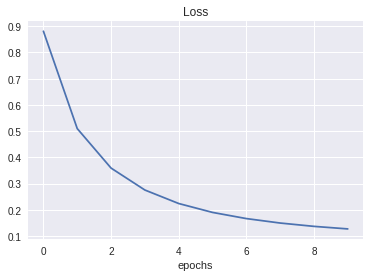

In [ ]:
# DO NOT MODIFY THIS CELL
losses_toy, params = train(init_params, update_weights, x_toy, y_true_toy, batch_size=1, num_epoch=10, learning_rate=1)
W_learned, b_learned = params

Теперь, когда у нас есть функция `train`, мы можем обучать нашу сеть в наборе данных 20 Newsgroups.

### 3.9

Теперь мы можем протестировать реализованные функции на нашем реальном наборе данных.

В ячейке ниже создайте матрицы `X` и` y_true`.

In [1]:
# place your code here

### 3.10 

Используя реализованную функцию train, теперь обучаем нейронную сеть в наборе данных Newsgroups. Как только сеть обучена, заполните код в функции `make_prediction`, которая делает прогнозы для заданных входных данных.

---
__Notes__:
- Напомним, что $\hat{y}_{pred} = \underset{j \in 1..k}{\text{argmax}}\left[\text{softmax}\left(\mathbf{z}\right)\right]$


Epoch: 0     Loss: 1.407
Epoch: 1     Loss: 1.006
Epoch: 2     Loss: 0.870
Epoch: 3     Loss: 0.781
Epoch: 4     Loss: 0.730
Epoch: 5     Loss: 0.757
Epoch: 6     Loss: 0.841
Epoch: 7     Loss: 0.814
Epoch: 8     Loss: 0.807
Epoch: 9     Loss: 0.769
Epoch: 10    Loss: 0.770
Epoch: 11    Loss: 0.735
Epoch: 12    Loss: 0.741
Epoch: 13    Loss: 0.707
Epoch: 14    Loss: 0.715
Epoch: 15    Loss: 0.683
Epoch: 16    Loss: 0.693
Epoch: 17    Loss: 0.661
Epoch: 18    Loss: 0.672
Epoch: 19    Loss: 0.641
Epoch: 20    Loss: 0.652
Epoch: 21    Loss: 0.622
Epoch: 22    Loss: 0.633
Epoch: 23    Loss: 0.604
Epoch: 24    Loss: 0.614
Epoch: 25    Loss: 0.587
Epoch: 26    Loss: 0.596
Epoch: 27    Loss: 0.570
Epoch: 28    Loss: 0.579
Epoch: 29    Loss: 0.554
Epoch: 30    Loss: 0.561
Epoch: 31    Loss: 0.538
Epoch: 32    Loss: 0.544
Epoch: 33    Loss: 0.522
Epoch: 34    Loss: 0.527
Epoch: 35    Loss: 0.506
Epoch: 36    Loss: 0.510
Epoch: 37    Loss: 0.490
Epoch: 38    Loss: 0.494
Epoch: 39    Loss: 0.475


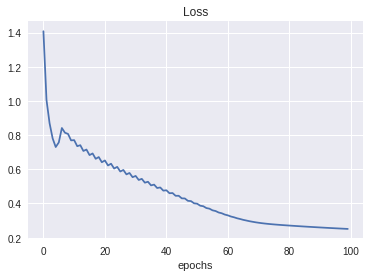

In [ ]:
# DO NOT MODIFY THIS CELL
losses, params = train(init_params, update_weights, x_train, y_train_ohe, batch_size=32, num_epoch=100, learning_rate=0.1, plot_loss=True)
W_learned, b_learned = params


In [ ]:
with open("weight.txt",'w') as f:
    for i in range(W_learned.shape[0]):
        f.write(str(W_learned[i])+'  '+ str())

In [ ]:
def make_prediction(x, W, b):
    """
        Make predictions for the given inputs x.

        x: np.array [N, d], inputs
        W: np.array, shape=[d, k], weights
        b: np.array, shape=[1, k], biases

        return: np.array of labels with shape [N]
    """
    # your code here
       
    
    return prediction

In [ ]:
y_pred = make_prediction(x_train, W_learned, b_learned)

In [ ]:
y_pred

array([2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1,
       0, 0, 2, 2, 1, 2, 0, 1, 2, 1, 0, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 0,
       1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 1, 2, 0,
       2, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0,
       1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 2, 1, 2, 1, 1,
       2, 2, 1, 2, 0, 1, 1, 2, 0, 0])

In [ ]:
accuracy = accuracy_score(Y_train, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.975


In [ ]:
y_pred = make_prediction(x_test, W_learned, b_learned)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 1.0


## 4 Let's add more layers!

Аналогично однослойной нейронной сети, двухслойная нейронная сеть выполняет следующие преобразования:
$$ \mathbf{z}^{(1)} = W^{(1)}\mathbf{x} + \mathbf{b^{(1)}} $$
$$ \mathbf{a}^{(1)} = f\left(\mathbf{z}^{(1)}\right)$$

$$ \mathbf{z}^{(2)} = W^{(2)}\mathbf{a^{(1)}} + \mathbf{b^{(2)}} $$
$$ \mathbf{\hat{y}} = \text{softmax}\left(\mathbf{z}^{(2)}\right)$$
где $f$ является активация первого линейного слоя. В нашей сети мы будем использовать функцию активации выпрямляющего линейного блока (Rectified Linear Unit (ReLU)), определенную как:

$$ f(x)=\text{ReLU(x)} = \max(0,x) $$

Соответствующие формулы для вычисления градиентов потерь в таком случае следующие:

$$ \frac{\partial \mathcal{L}}{\partial W^{(2)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial  \mathbf{z}^{(2)}}{\partial W^{(2)}}$$

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(2)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{b}^{(2)}}$$


$$ \frac{\partial \mathcal{L}}{\partial W^{(1)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial a^{(1)}} \cdot \frac{\partial a^{(1)}}{\partial \mathbf{z}^{(1)}} \cdot \frac{\partial\mathbf{z}^{(1)}}{\partial W^{(1)}}  $$

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(1)}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial a^{(1)}} \cdot \frac{\partial a^{(1)}}{\partial \mathbf{z}^{(1)}} \cdot \frac{\partial\mathbf{z}^{(1)}}{\partial \mathbf{b}^{(1)}}  $$

В данной нотации $W^{(1)} \in \mathbb{R}^{m\times d_2}$, $W^{(2)} \in \mathbb{R}^{d_2\times k}$,  $\mathbf{b}^{(1)} \in \mathbb{R}^{d_2}$ и $\mathbf{b}^{(2)} \in \mathbb{R}^{k}$.


### 4.1 

Как и в разделах 3.2 и 3.6, выполните проход прямого и обратного распространения через функцию ReLU (используя ее определение).

---

__Notes__:
- В `relu_backward` переменная` a_grad` обозначает  $\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(2)}} \cdot \frac{\partial \mathbf{z}^{(2)}}{\partial a^{(1)}}$


In [ ]:
def relu(z):
    """
        Compute relu activation as max(z, 0)
        
        z: np.array, shape=[m, d]

        Return: np.array, shape=[m, d]
    """
    # your code here
    
    return _z

In [ ]:
def relu_backward(z, a_grad):
    """
        Return gradient of loss with respect to input z given the output gradient.

        z: np.array, shape=[m, d] input to relu, not the output
        
        return: gradient dL/dz np.array, shape=[m, d]
    """
    # your code here
    
    return dldz

### 4.2 

Выполните прямое распространение для двухслойной нейронной сети, дополнив код в `neural_network`

In [ ]:
def neural_network(x, W1, b1, W2, b2):
    """
        Use layers created above to define two-layer neural network with relu activation.

        x: np.array, shape=[m, n_features_tst]
        W1: np.array, shape=[m, d2] first layer weights
        W2: np.array, shape=[d2, k] second layer weights
        b1: np.array, shape=[1, d2] first layer bias
        b2: np.array, shape=[1, k] second layer bias

        return: tuple, output of the linear layer, output of the relu, output of the final linear layer
    """
    # your code here
    
    return (z1, a1, z2)

### 4.3

Дополните код `neural_network_backward` который вычисляет градиенты функции потерь относительно каждого веса.

---
__Notes__:
- Вы должны вызвать уже реализованные функции обратного распространения в ячейке ниже.

In [ ]:
def neural_network_backward(x, W1, b1, W2, b2, z1, a1, z2, z2_grad):
    """
        Compute gradients of loss with respect to inputs x, W1, b1, W2, and b2.

        x: np.array, shape=[m, d] input
        W1: np.array, shape=[m, d2] first layer weights
        b1: np.array, shape=[1, d2] first layer bias
        W2: np.array, shape=[d2, k] second layer weights
        b2: np.array, shape=[1, k] second layer bias

        z1, z2, z3: np.array activations of linear, relu, and linear layers
        z3_grad: np.array, shape=[m, k] gradient of loss with respect to network output dL/dz3

        return: tuple: gradients dL/dW1, dL/db1, dL/dW2, dL/db2
    """
        # your code here
        
    return W1_grad, b1_grad, W2_grad, b2_grad

### 4.4

Дополните код `update_neural_network_weights`.

In [ ]:
def init_neural_network_params(x, y_true):
    """
        Initialize weights and biases of two layer neural network, given input data.
        
        x: np.array, shape=[m, d] input
        y_true: np.array, shape=[m, k] true label one-hot
        
        return: list of np.array parameters
    """
    n_features = x.shape[1]
    n_classes = y_true.shape[1]
    n_middle = n_classes * 4  # we arbitrarily pick the middle layer size to be 4 times bigger than the output

    # Initialize W from normal distribution and b with zeros
    
    
    return [W1, W2, b1, b2]

def update_neural_network_weights(params, x, y_true, alpha, lam=0.001):
    """
        Given neural network parameters, update parameters and return loss.
        
        params: list of np.array parameters
        x: np.array, shape=[m, d] input
        y_true: np.array, shape=[m, k] output labels one-hot
        alpha: learning rate (float)
        lam: lambda regularization constant (float)
        
        return: float sum of cross entropy loss and L2 regularization losses
    """
    # place your code below
    
    # place your code above
    W1 -= alpha * (W1_grad + W1_reg_grad)
    W2 -= alpha * (W2_grad + W2_reg_grad)
    b1 -= alpha * (b1_grad + b1_reg_grad)
    b2 -= alpha * (b2_grad + b2_reg_grad)
    return loss  + reg_loss

### 4.5
Дополните код в функции `make_prediction_network` аналогично разделу 3.10.

In [ ]:
def make_prediction_network(x, W1, b1, W2, b2):
    """
        Make predictions for the given inputs x.

        x: np.array, shape=[m, d] input
        W1: np.array, shape=[m, d2] first layer weights
        b1: np.array, shape=[1, d2] first layer bias
        W2: np.array, shape=[d2, k] second layer weights
        b2: np.array, shape=[1, k] second layer bias

        return: np.array of labels with shape [N]
    """
    # your code here
    
    return prediction, sm

Epoch: 0     Loss: 1.189
Epoch: 1     Loss: 1.149
Epoch: 2     Loss: 1.119
Epoch: 3     Loss: 1.095
Epoch: 4     Loss: 1.075
Epoch: 5     Loss: 1.057
Epoch: 6     Loss: 1.043
Epoch: 7     Loss: 1.030
Epoch: 8     Loss: 1.018
Epoch: 9     Loss: 1.007
Epoch: 10    Loss: 0.996
Epoch: 11    Loss: 0.986
Epoch: 12    Loss: 0.976
Epoch: 13    Loss: 0.967
Epoch: 14    Loss: 0.958
Epoch: 15    Loss: 0.950
Epoch: 16    Loss: 0.942
Epoch: 17    Loss: 0.934
Epoch: 18    Loss: 0.926
Epoch: 19    Loss: 0.919
Epoch: 20    Loss: 0.912
Epoch: 21    Loss: 0.905
Epoch: 22    Loss: 0.899
Epoch: 23    Loss: 0.892
Epoch: 24    Loss: 0.884
Epoch: 25    Loss: 0.873
Epoch: 26    Loss: 0.863
Epoch: 27    Loss: 0.853
Epoch: 28    Loss: 0.844
Epoch: 29    Loss: 0.836
Epoch: 30    Loss: 0.828
Epoch: 31    Loss: 0.820
Epoch: 32    Loss: 0.814
Epoch: 33    Loss: 0.808
Epoch: 34    Loss: 0.802
Epoch: 35    Loss: 0.796
Epoch: 36    Loss: 0.791
Epoch: 37    Loss: 0.787
Epoch: 38    Loss: 0.782
Epoch: 39    Loss: 0.778


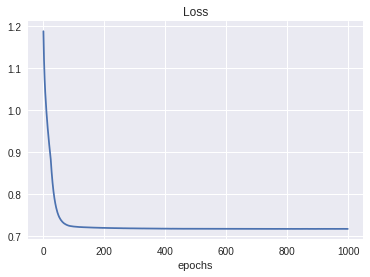

In [ ]:
# Test the neural network on the toy dataset
losses_nn, params_nn = train(init_neural_network_params, update_neural_network_weights, x_toy, y_true_toy, batch_size=1, num_epoch=1000, learning_rate=0.1, plot_loss=True, lam=0.001)#, verbose=False)

### 4.6 Let's train!

Epoch: 0     Loss: 1.265
Epoch: 1     Loss: 1.180
Epoch: 2     Loss: 1.117
Epoch: 3     Loss: 1.057
Epoch: 4     Loss: 0.998
Epoch: 5     Loss: 0.941
Epoch: 6     Loss: 0.890
Epoch: 7     Loss: 0.846
Epoch: 8     Loss: 0.811
Epoch: 9     Loss: 0.784
Epoch: 10    Loss: 0.763
Epoch: 11    Loss: 0.747
Epoch: 12    Loss: 0.733
Epoch: 13    Loss: 0.722
Epoch: 14    Loss: 0.713
Epoch: 15    Loss: 0.705
Epoch: 16    Loss: 0.698
Epoch: 17    Loss: 0.692
Epoch: 18    Loss: 0.686
Epoch: 19    Loss: 0.681


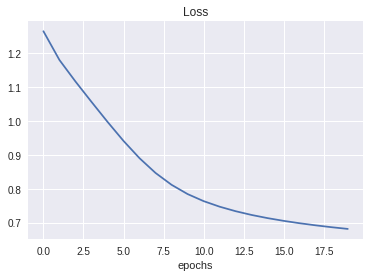

In [ ]:
# Now, we train on the real dataset!
losses_nn, params_nn = train(init_neural_network_params, update_neural_network_weights,  x_train, y_train_ohe, batch_size=32, num_epoch=20, learning_rate=0.1, plot_loss=True, lam=0.1)#, plot_per_epoch=False)
W1_learned_nn, W2_learned_nn, b1_learned_nn, b2_learned_nn = params_nn

In [ ]:
y_pred_nn, prob = make_prediction_network(x_train, W1_learned_nn, b1_learned_nn, W2_learned_nn, b2_learned_nn)

In [ ]:
print(y_pred_nn)

[2 2 1 2 2 0 1 2 1 2 0 1 1 0 2 1 2 0 2 1 2 1 0 0 2 2 1 2 0 1 2 2 0 2 0 1 0
 2 2 0 2 2 2 0 1 0 2 1 0 2 0 1 2 1 2 1 1 2 2 0 2 0 0 1 2 0 2 2 0 0 0 2 2 1
 1 1 1 0 0 0 1 2 2 0 0 0 2 0 1 0 1 0 2 1 2 0 2 0 1 1 0 2 2 2 0 2 1 2 2 1 2
 2 1 2 0 2 1 2 0 0]


In [ ]:
np.shape(Y_train)

(120,)

In [ ]:
accuracy_nn = accuracy_score(Y_train, y_pred_nn)
print('Accuracy NN:', accuracy_nn)

Accuracy NN: 0.9166666666666666


In [ ]:
y_pred_nn, prob = make_prediction_network(x_test, W1_learned_nn, b1_learned_nn, W2_learned_nn, b2_learned_nn)

In [ ]:
np.shape(y_pred_nn)

(30,)

In [ ]:
accuracy = accuracy_score(Y_test, y_pred_nn)
print('Accuracy:', accuracy)

Accuracy: 1.0
